# Homework 2

In [57]:
import numpy as np
from scipy.stats import multivariate_normal

#import dataset
dataset = np.load('dataset.npy')

#how many Gaussians are mixed
gaussianAmt = 3

#dimension of data in dataset
dim = len(dataset[0])

#treshold for checking numerical errors for randomization and singularity
numericalErrorTreshold = 1e-6

#addition factor for singular covariance matrix during the M-step
#if the new covariance matrix becomes singular, factor*I will be added to it
singularityAdditionFactor = 1e-6

Necessary libraries are imported. PDF of multivariate normal distribution is calculated with built-in function from scipy library. 

* gaussianAmt variable keeps how many Gaussian distributions are mixed in the dateset.
* dim variable keeps the dimension of the dataset.
* numericalErrorTreshold variable keeps the tolerable amount of numerical errors for randomization and singularity. Its use will be detailed in next parts.
* singularityAdditionFactor variable keeps the amount of addition factor to the covariance matrix obtained in M-step of the algorithm. Its use is suggested in the link given below because the obtained new covariance matrix may become singular and it cannnot be used in PDF of multivariate normal distriburion. This tiny addition assures the algorithm may continue if ever a non-singular covariance matrix is obtained during the algorithm and I have witnessed its usefulness during my tests.

Link: https://www.researchgate.net/post/How_to_fix_co_variance_matrix_going_singular_in_Gaussian_mixture_model_implementation

In [58]:
#mean, covariance and mixing coefficient arrays
means = []
covariances = []
coeffs = []

#filling the arrays randomly
for k in range(gaussianAmt):
    means.append(np.random.uniform(-10, 10, dim))
    #for covariance matrix, it needs to be positive semi-definite
    posSemiDef = False
    while posSemiDef == False:
        A = np.random.uniform(-10, 10, (dim, dim))
        #A^T * A is positive semi-definite
        covariances.append(np.matmul(A.T, A))
        #check if it is not positive semi-definite due to numerical error
        #its eigenvalues must be all positive
        posSemiDef = np.all(np.linalg.eigvalsh(covariances[k]) > numericalErrorTreshold)
        if posSemiDef == False:
            covariances.pop(k)
            
    coeffs.append(np.random.uniform(-10, 10))

#calculating softmax of coeffs in order to make its sum = 1
coeffs = np.exp(coeffs) / np.sum(np.exp(coeffs))

#log likelihood value calculation
logLikelihood = 0
for n, data in enumerate(dataset):
    sumWeightedProb = 0
    for k in range(gaussianAmt):
        weightedProb = coeffs[k]*multivariate_normal.pdf(data, means[k], covariances[k])
        sumWeightedProb += weightedProb
    logLikelihood += np.log(sumWeightedProb)

In this step, random initial mean, covariance and mixture coefficients are calculated.

* All values are randomized uniformly between -10 and 10.
* Covariance matrix needs to be positive semi-definite. Because of that during its random initialization, one needs to be cautious. First of all, a matrix $A$ is randomized. Since $A^T \times A$ is positive semi-definite, the random covariance matrix is chosen as such. A control is done for its positive semi-definiteness by checking if its all eigenvalues are positive.
* The sum of mixture coefficients needs to be equal to 1. In order to ensure that, coeffients are randomized first and then its softmax is calculated. Sum of elements of an array after softmax process is equal to 1. Details of softmax can be seen in the link below:

Link: https://en.wikipedia.org/wiki/Softmax_function

* In the last step, initial log likelihood for mixture of multivariate normal distributions is calculated. Log likelihood value will be used for convergence control of the algorithm.

In [59]:
#treshold for stopping the algorithm
convergenceTreshold = 1e-6
stopAlgorithm = False
#iteration counter
nIter = 0

while stopAlgorithm == False:
    #E-step
    mvGaussianProbWithCoeffs = []
    condProbZ_nk = []
    for n, data in enumerate(dataset):
        mvGaussianProbWithCoeffs.append([])
        condProbZ_nk.append([])
        sumWeightedProb = 0
        for k in range(gaussianAmt):
            #probability of each data for each mixed Gaussian is calculated and weighted by corresponding mixture
            #coefficient
            weightedProb = coeffs[k]*multivariate_normal.pdf(data, means[k], covariances[k])
            mvGaussianProbWithCoeffs[n].append(weightedProb)
            #their sum is calculated
            sumWeightedProb += weightedProb
        for k in range(gaussianAmt):
            #conditional probability of latent variable z is calculated
            condProbZ_nk[n].append(mvGaussianProbWithCoeffs[n][k]/sumWeightedProb)
    

    #M-step
    N_k = []
    N = len(dataset)
    meansNew = []
    covariancesNew = []
    coeffsNew = []

    for k in range(gaussianAmt):
        N_k.append(0)
        meansNew.append(np.zeros(dim))
        covariancesNew.append(np.zeros((dim, dim)))
        coeffsNew.append(np.zeros(dim))
        
        #new means
        for n, data in enumerate(dataset):
            N_k[k] += condProbZ_nk[n][k]
            meansNew[k] += condProbZ_nk[n][k]*data
        meansNew[k] /= N_k[k]
        
        #new covariances
        for n, data in enumerate(dataset):
            covariancesNew[k] += condProbZ_nk[n][k]*np.matmul((data-meansNew[k]).reshape(dim,1), (data-meansNew[k]).reshape(dim,1).T)
        covariancesNew[k] /= N_k[k]  
        
        #new coeffs
        coeffsNew[k] = N_k[k]/N
        
        means[k] = meansNew[k]
        covariances[k] = covariancesNew[k]
        #if covariances are singular, i.e the determinant is zero then a tiny addition is done to its diagonal
        #to make sure it is not singular so it can be used in PDF of multivariate normal distribution
        if (np.linalg.det(covariances[k]) < numericalErrorTreshold):
            covariances[k] += singularityAdditionFactor*np.eye(dim)
        coeffs[k] = coeffsNew[k]
    
    #convergence check
    logLikelihoodIter = 0
    #new log likelihood is calculated
    for n, data in enumerate(dataset):
        sumWeightedProb = 0
        for k in range(gaussianAmt):
            weightedProb = coeffs[k]*multivariate_normal.pdf(data, means[k], covariances[k])
            sumWeightedProb += weightedProb
        logLikelihoodIter += np.log(sumWeightedProb)
    
    #if difference below the treshold, stop the algorithm
    if abs(logLikelihoodIter - logLikelihood) < convergenceTreshold:
        stopAlgorithm = True
    
    nIter += 1
    
    print('Iteration '+str(nIter)+': Log likelihood value difference: '+str(abs(logLikelihoodIter - logLikelihood)))
    
    logLikelihood = logLikelihoodIter 

Iteration 1: Log likelihood value difference: 553.4759472136986
Iteration 2: Log likelihood value difference: 0.17537641866329068
Iteration 3: Log likelihood value difference: 0.15718216197319634
Iteration 4: Log likelihood value difference: 0.19082009761018526
Iteration 5: Log likelihood value difference: 0.23011771130882153
Iteration 6: Log likelihood value difference: 0.26703648089505805
Iteration 7: Log likelihood value difference: 0.2928775634527483
Iteration 8: Log likelihood value difference: 0.29919309640376923
Iteration 9: Log likelihood value difference: 0.2832740453693532
Iteration 10: Log likelihood value difference: 0.2511115651179807
Iteration 11: Log likelihood value difference: 0.21396788389370158
Iteration 12: Log likelihood value difference: 0.1819706349367607
Iteration 13: Log likelihood value difference: 0.16031353730932096
Iteration 14: Log likelihood value difference: 0.14964588202951745
Iteration 15: Log likelihood value difference: 0.14945661936030774
Iteration 

In this step, algorithm is implemented.

* Firstly, convergence treshold is decided. The algorithm works until convergence is obtained.
* The algorithm starts with E-step. In this step, conditional probability of latent variable z is calculated. First of all, probabilities of each data for each mixed Gaussian is calculated and weighted with the corresponding mixture coefficient. Their values are stored in mvGaussianProbWithCoeffs array and sum of probabilities of each data is kept in  variable sumWeightedProb of every Gaussian. Then, the conditional probability of z is calculated by division of probability of each data being in a Gaussian and sum of all probabilities of all the Gaussians of that data.
* Next step is N-step. In this step, new means, covariances and mixture coefficients are calculated. Firstly, new means are calculated by weighted average of data in dataset with corresponding conditional probability of corresponding latent value z. Then new covariances are calculated. New covariances of data are calculated by using the new means. After calculating the new covariances, the matrix may become singular which is not useful for probability calculation with PDF of multivariate normal distribution. In order to make it useful for the calculation, a very tiny factor is added to its diagonal so the algorithm may continue and it converges. There are other methods for circumventing the singularity problem such as re-initializing the covariance matrix etc. However, this little addition method is also accepted by literature and used in practice. The link is given in the initialization of the little factor. Finally, the new mixture coefficients are calculated by taking the average of conditional probabilities of latent variable z for each mixture.
* The arrays are updated by the new ones.
* For convergence, log likelihood is re-calculated with the new updated values. If the difference between log likelihood of previous step and current step is below the treshold, the algorithm stops.
* In order to see the process and iteration count of the algorithm, iteration count and log likelihood differences are printed. In this example, the algorithm converges in 49 iterations.

In [60]:
print("Final means: ")
for k in range(gaussianAmt):
    print(str(k+1)+': '+str(means[k]))
    
print("\nFinal covariances: ")
for k in range(gaussianAmt):
    print(str(k+1)+': '+str(covariances[k]))
    
print("\nFinal coefficients: ")
for k in range(gaussianAmt):
    print(str(k+1)+': '+str(coeffs[k]))

Final means: 
1: [0.70208114 0.66135866]
2: [9.60515914 9.16835945]
3: [4.3790422  4.35183625]

Final covariances: 
1: [[ 2.11797449 -0.09973663]
 [-0.09973663  0.64083105]]
2: [[ 2.01245136 -0.64166751]
 [-0.64166751  0.82171149]]
3: [[ 2.74790459 -0.11922352]
 [-0.11922352  0.6180689 ]]

Final coefficients: 
1: 0.333164749246527
2: 0.3333333160484921
3: 0.33350193470498074


Estimated values can be seen above for this example. However, these values may alter due to random initialization of the means, covariances and mixture coefficients.

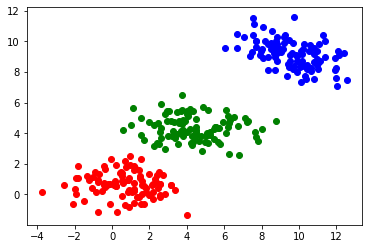

In [76]:
import matplotlib.pyplot as plt

#decide clusters for data accoring to conditional probability of latent variable z for each data
clusters = []
for k in range(gaussianAmt):
    clusters.append([])

for n, data in enumerate(dataset):
    prob = 0
    cluster = 0
    for k in range(gaussianAmt):
        probCluster = coeffs[k]*multivariate_normal.pdf(data, means[k], covariances[k])
        if probCluster > prob:
            prob = probCluster
            cluster = k
    clusters[cluster].append(n)
    
colors = ['red', 'blue', 'green', 'gray', 'yellow', 'cyan', 'magenta']

#plot data according to their clusters decided
for k in range(gaussianAmt):
    for n in clusters[k]:
        plt.scatter(dataset[n][0], dataset[n][1], c=colors[k])


Above the data is clustered and plotted in different colors regarding the clusters. Clustering is done by comparing the conditional probability of latent value z of each data. According to the plot above, it seems that EM algorithm provides an accurate assumption for parameters and mixture coefficients of mixture of distributions for the data.